In [1]:
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
os.getcwd()
#path = os.chdir('C:/Users/vivek/Desktop/575_Project')
path = os.chdir('C:/Users/shrut/OneDrive/Desktop/Shruti/UIC/IDS 575/Project')
#path = os.chdir('D:/UIC/Spring 2020/IDS 575 - ML/HomeWork Assn/Project')
#!pip install imblearn
fct = pd.read_csv("covtype.csv")
fct.head(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
def forest(x):
    if x==1:
        return 'Spruce/Fir'
    elif x==2:
        return 'Lodgepole Pine'
    elif x==3:
        return 'Ponderosa Pine'
    elif x==4:
        return 'Cottonwood/Willow'
    elif x==5:
        return 'Aspen'
    elif x==6:
        return 'Douglas-fir'
    elif x==7:
        return 'Krummholz'  
fct['Cover_Type'] = fct['Cover_Type'].apply(lambda x: forest(x))

In [4]:
newfct=fct[fct.columns[:10]]
#Understanding outliers and removing them from the data
def find_out(quant,col):
    Q3 = quant[col].quantile(0.75)
    Q1 = quant[col].quantile(0.25)
    IQR = Q3 - Q1
    count_ol=0
    ul = Q3+(2*1.5*IQR)
    ll = Q1-(2*1.5*IQR)
    
    for i in quant[col]:
        if (i< ll) |(i > ul):
            count_ol +=1
    return ll, ul, count_ol
            
for columns in newfct:
            if find_out(newfct, columns)[2] > 0:
                print("Total {} outliers in {}".format(find_out(newfct, columns)[2], columns))

Total 275 outliers in Slope
Total 414 outliers in Horizontal_Distance_To_Hydrology
Total 5339 outliers in Vertical_Distance_To_Hydrology
Total 1027 outliers in Hillshade_9am
Total 1191 outliers in Hillshade_Noon
Total 10 outliers in Horizontal_Distance_To_Fire_Points


In [5]:
#Deleting outliers for Vertical_Distance_To_Hydrology, Hillshade_9am, Hillshade_Noon
fct= fct[(fct['Vertical_Distance_To_Hydrology'] > find_out(fct, 'Vertical_Distance_To_Hydrology')[0])
& (fct['Vertical_Distance_To_Hydrology'] < find_out(fct, 'Vertical_Distance_To_Hydrology')[1])]

fct= fct[(fct['Hillshade_9am'] > find_out(fct, 'Hillshade_9am')[0])
& (fct['Hillshade_9am'] < find_out(fct, 'Hillshade_9am')[1])]

fct= fct[(fct['Hillshade_Noon'] > find_out(fct, 'Hillshade_Noon')[0])
& (fct['Hillshade_Noon'] < find_out(fct, 'Hillshade_Noon')[1])]

total_rows = fct.count
#print (total_rows)

In [6]:
#Data transformations
#Eucledian distance because hydrology has -ve values

fct['Euclidian_Hydro'] = np.sqrt((fct['Horizontal_Distance_To_Hydrology']**2 +fct['Vertical_Distance_To_Hydrology']**2))
fct['Elev_Vert_Hydro_mean'] = (fct['Elevation'] + fct['Vertical_Distance_To_Hydrology'])/2
fct['Fire_Horz_Hydro_mean'] = (fct['Horizontal_Distance_To_Hydrology'] +fct['Horizontal_Distance_To_Fire_Points'])/2
fct['Hydro_Horz_Road_mean'] = (fct['Horizontal_Distance_To_Hydrology'] + fct['Horizontal_Distance_To_Roadways'])/2
fct['Fire_Road_mean'] = (fct['Horizontal_Distance_To_Fire_Points'] + fct['Horizontal_Distance_To_Roadways'])/2

fct= fct.drop(['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Roadways'], axis=1)

In [7]:
#Data transformations
#Changing bimodal Aspect to Normal distribution
from scipy import stats
import statistics
fct['Aspect_Shap']=(abs(fct['Aspect'] - statistics.mean(fct['Aspect'])))
fct= fct.drop(['Aspect'], axis=1)

In [8]:
#Transforming variables to follow normal distribution
fct['Sqrt_Fire_Horz_Hydro_mean'] = np.sqrt(fct['Fire_Horz_Hydro_mean'])
fct['Sqrt_Hydro_Horz_Road_mean'] = np.sqrt(fct['Hydro_Horz_Road_mean'])
#fct['Sqrt_Fire_Road_mean'] = np.sqrt(fct['Fire_Road_mean'])
fct= fct.drop(['Fire_Horz_Hydro_mean','Hydro_Horz_Road_mean'], axis=1)

In [9]:
fct.head(5)

,Elevation,Slope,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,...,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Euclidian_Hydro,Elev_Vert_Hydro_mean,Fire_Road_mean,Aspect_Shap,Sqrt_Fire_Horz_Hydro_mean,Sqrt_Hydro_Horz_Road_mean
0,2596,3,221,232,148,1,0,0,0,0,...,0,0,0,Aspen,258.000000,1298.0,3394.5,104.22934,57.170797,19.595918
1,2590,2,220,235,151,1,0,0,0,0,...,0,0,0,Aspen,212.084889,1292.0,3307.5,99.22934,56.731825,17.349352
2,2804,9,234,238,135,1,0,0,0,0,...,0,0,0,Lodgepole Pine,275.769832,1434.5,4650.5,16.22934,56.519908,41.521079
3,2785,18,238,238,122,1,0,0,0,0,...,0,0,0,Lodgepole Pine,269.235956,1451.5,4650.5,0.22934,56.802289,40.816663
4,2595,2,220,234,150,1,0,0,0,0,...,0,0,0,Aspen,153.003268,1297.0,3281.5,110.22934,56.236109,16.492423


In [10]:
#Data-Modelling
y=fct['Cover_Type']
X = fct.drop('Cover_Type', axis=1)

In [11]:
#from sklearn.preprocessing import label_binarize
#y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7])
#n_classes = y.shape[1]
#print(y)

In [12]:
#Removing features with low variable importance and kurtosis 
rem=['Hillshade_3pm','Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type14','Soil_Type15','Soil_Type19','Soil_Type20',
     'Soil_Type21','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type36','Soil_Type37']
X.drop(rem, axis=1, inplace=True)

In [37]:
#Splitting the data into test and train
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X,y, test_size=0.3, random_state=100)

In [14]:
#Technique 1 - calculating class weights
unique_classes=list(y_train_set.unique())
print(unique_classes)
class_wt={}

for classes in unique_classes:
    class_wt[classes]=y_train_set.shape[0]/((y_train_set.loc[y_train_set==classes].shape[0])*len(unique_classes))
print("The class weights for each cover type are:",class_wt)
print("This is minority class sample --in decreasing order of proportion")

['Spruce/Fir', 'Krummholz', 'Lodgepole Pine', 'Ponderosa Pine', 'Aspen', 'Douglas-fir', 'Cottonwood/Willow']
The class weights for each cover type are: {'Spruce/Fir': 0.3911524461532311, 'Krummholz': 4.195824529841223, 'Lodgepole Pine': 0.2919470145272653, 'Ponderosa Pine': 2.3590717696596175, 'Aspen': 8.774547761226676, 'Douglas-fir': 4.791118755001373, 'Cottonwood/Willow': 30.066406835556887}
This is minority class sample --in decreasing order of proportion


We observe that cottonwoon/willow has the maximum weight showing that its a minority class. As we do not want to bias the models much to favor more accurate predictions of the higher weighted class hence balancing the class weights in the next step.

In [15]:
#class_wt= {'Lodgepole Pine':10, 'Spruce/Fir':10, 'Ponderosa Pine':15, 'Cottonwood/Willow':30, 'Aspen':20, 'Douglas-fir':12 , 'Krummholz':12}


In [16]:
class_wt

{'Spruce/Fir': 0.3911524461532311,
 'Krummholz': 4.195824529841223,
 'Lodgepole Pine': 0.2919470145272653,
 'Ponderosa Pine': 2.3590717696596175,
 'Aspen': 8.774547761226676,
 'Douglas-fir': 4.791118755001373,
 'Cottonwood/Willow': 30.066406835556887}

In [17]:
#Technique 2: Re-sampling- Undersample 
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X_train_us, y_train_us = undersample.fit_resample(X_train_set, y_train_set)
# summarize the new class distribution
counter = Counter(y_train_us)
print(counter)

Counter({'Aspen': 1906, 'Cottonwood/Willow': 1906, 'Douglas-fir': 1906, 'Krummholz': 1906, 'Lodgepole Pine': 1906, 'Ponderosa Pine': 1906, 'Spruce/Fir': 1906})


In [18]:
#Technique 2: Oversampling using RandomOverSampler inimblearn
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_set == 'Lodgepole Pine'))) 
print("Before OverSampling, counts of label '2': {}".format(sum(y_train_set == 'Spruce/Fir')))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train_set == 'Ponderosa Pine'))) 
print("Before OverSampling, counts of label '4': {}".format(sum(y_train_set == 'Cottonwood/Willow')))
print("Before OverSampling, counts of label '5': {}".format(sum(y_train_set == 'Aspen')))
print("Before OverSampling, counts of label '6': {}".format(sum(y_train_set == 'Douglas-fir'))) 
print("Before OverSampling, counts of label '7': {}".format(sum(y_train_set == 'Krummholz'))) 
print(X_train_set.shape)
print(y_train_set.shape)

Before OverSampling, counts of label '1': 196291
Before OverSampling, counts of label '2': 146507
Before OverSampling, counts of label '3': 24292
Before OverSampling, counts of label '4': 1906
Before OverSampling, counts of label '5': 6531
Before OverSampling, counts of label '6': 11961
Before OverSampling, counts of label '7': 13658
(401146, 40)
(401146,)


In [19]:
#RandomOversampler
from imblearn.over_sampling import SMOTE
import imblearn

#ss ={'Lodgepole Pine':196291, 'Spruce/Fir':146507, 'Ponderosa Pine':100000, 'Cottonwood/Willow':100000, 'Aspen':100000, 'Douglas-fir':100000 , 'Krummholz':100000}
#smote=SMOTE('minority')
smote= imblearn.over_sampling.RandomOverSampler(random_state=0)

X_train_os, y_train_os = smote.fit_sample(X_train_set, y_train_set)
print(X_train_os.shape)
print(y_train_os.shape)

(1374037, 40)
(1374037,)


In [20]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_os == 'Lodgepole Pine'))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_os == 'Spruce/Fir')))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_os == 'Ponderosa Pine'))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_os == 'Cottonwood/Willow')))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_os == 'Aspen')))
print("After OverSampling, counts of label '6': {}".format(sum(y_train_os == 'Douglas-fir'))) 
print("After OverSampling, counts of label '7': {}".format(sum(y_train_os == 'Krummholz'))) 

After OverSampling, counts of label '1': 196291
After OverSampling, counts of label '2': 196291
After OverSampling, counts of label '3': 196291
After OverSampling, counts of label '4': 196291
After OverSampling, counts of label '5': 196291
After OverSampling, counts of label '6': 196291
After OverSampling, counts of label '7': 196291


In [21]:
#Dummy Classifier

In [22]:
#Naive Bayes Without Class Weights/Oversampling
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
gnb = GaussianNB()
gnb.fit(X_train_set,y_train_set)
y_pred = gnb.predict(X_test_set)
NB_accuracy =(y_test_set == y_pred).sum() / X_test_set.shape[0]
NB_accuracy
print(metrics.classification_report(y_test_set, y_pred))
print(metrics.confusion_matrix(y_test_set, y_pred))

                   precision    recall  f1-score   support

            Aspen       0.08      0.69      0.14      2913
Cottonwood/Willow       0.18      0.93      0.30       836
      Douglas-fir       0.46      0.05      0.10      5248
        Krummholz       0.36      0.84      0.50      5955
   Lodgepole Pine       0.82      0.16      0.27     83654
   Ponderosa Pine       0.41      0.73      0.53     10345
       Spruce/Fir       0.51      0.76      0.61     62969

         accuracy                           0.45    171920
        macro avg       0.40      0.59      0.35    171920
     weighted avg       0.64      0.45      0.41    171920

[[ 2006     0     7     0    74   442   384]
 [    0   777     0     0     0    59     0]
 [  319   946   282     0    80  3547    74]
 [    2     0     0  5002    53    11   887]
 [19060    89   243   934 13369  6042 43917]
 [  275  2479    55     0    10  7513    13]
 [ 3742     0    26  7961  2794   506 47940]]


In [23]:
# from sklearn.metrics import roc_curve, auc
# def plot_multiclass_roc(clf, X_test_set, y_test_set, n_classes, figsize=(17, 6)):
#     y_pred = clf.predict(X_test_set)

#     # structures
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()

#     # calculate dummies once
#     y_test_dummies = pd.get_dummies(y_test_set, drop_first=False).values
#     for i in range(n_classes):
#         fpr[i], tpr[i],_ = roc_curve(y_test_dummies, y_pred,pos_label=n_classes[i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # roc for each class
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.plot([0, 1], [0, 1], 'k--')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic example')
#     for i in range(n_classes):
#         ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
#     ax.legend(loc="best")
#     ax.grid(alpha=.4)
#     sb.despine()
#     plt.show()

# plot_multiclass_roc(gnb, X_test_set, y_test_set, n_classes=7, figsize=(16, 10))

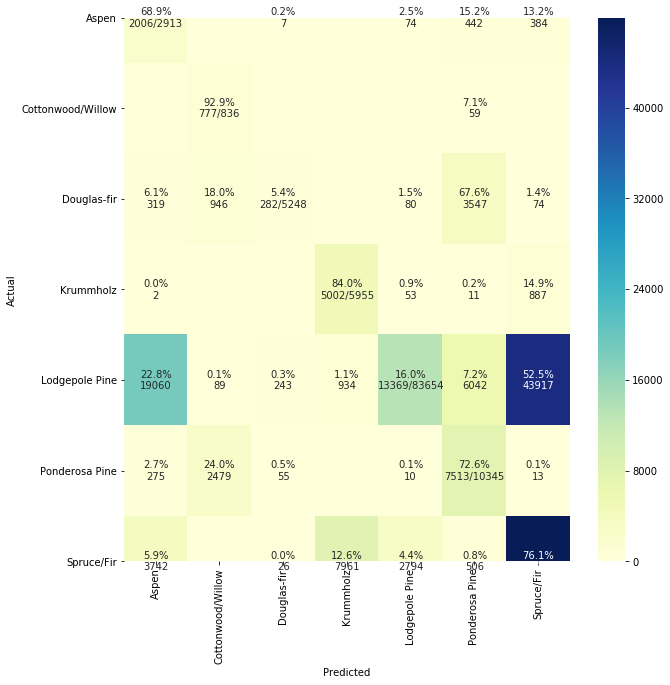

In [24]:
#Confusion Matrix for Naive Bayes Without Class Weights/Oversampling
from sklearn.metrics import confusion_matrix
%matplotlib inline
def plot_cm(y_test_set, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_test_set, y_pred, labels=np.unique(y_test_set))
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test_set), columns=np.unique(y_test_set))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sb.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test_set, y_pred)

In [25]:
#Naive Bayes - Under sampling

gnb = GaussianNB()
gnb.fit(X_train_us,y_train_us)

y_pred1 = gnb.predict(X_test_set)

NB_accuracy =(y_test_set == y_pred1).sum() / X_test_set.shape[0]
NB_accuracy
print(metrics.classification_report(y_test_set, y_pred1))
print(metrics.confusion_matrix(y_test_set, y_pred1))

                   precision    recall  f1-score   support

            Aspen       0.03      0.68      0.06      2913
Cottonwood/Willow       0.13      0.94      0.23       836
      Douglas-fir       0.26      0.56      0.36      5248
        Krummholz       0.11      0.89      0.20      5955
   Lodgepole Pine       0.70      0.01      0.01     83654
   Ponderosa Pine       0.52      0.06      0.11     10345
       Spruce/Fir       0.35      0.25      0.29     62969

         accuracy                           0.16    171920
        macro avg       0.30      0.48      0.18    171920
     weighted avg       0.51      0.16      0.14    171920

[[ 1977     0    92    36    11     0   797]
 [    0   782    50     0     0     4     0]
 [  477  1265  2939     7     5   189   366]
 [  246     0     0  5291     0     0   418]
 [38114   332  3433 13260   454   364 27697]
 [ 1233  3534  4292     0    24   612   650]
 [17589     0   298 28901   156     0 16025]]


In [26]:
#Naive Bayes - over sampling
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
#gnb = MultinomialNB()
gnb = GaussianNB()

gnb.fit(X_train_os,y_train_os)

y_pred2 = gnb.predict(X_test_set)

NB_accuracy =(y_test_set == y_pred2).sum() / X_test_set.shape[0]
NB_accuracy
print(metrics.classification_report(y_test_set, y_pred2))
print(metrics.confusion_matrix(y_test_set, y_pred2))

                   precision    recall  f1-score   support

            Aspen       0.06      0.78      0.11      2913
Cottonwood/Willow       0.12      0.95      0.21       836
      Douglas-fir       0.48      0.05      0.09      5248
        Krummholz       0.29      0.88      0.44      5955
   Lodgepole Pine       0.84      0.13      0.23     83654
   Ponderosa Pine       0.40      0.60      0.48     10345
       Spruce/Fir       0.53      0.69      0.60     62969

         accuracy                           0.40    171920
        macro avg       0.39      0.58      0.31    171920
     weighted avg       0.65      0.40      0.38    171920

[[ 2262     0     7     0    50   437   157]
 [    0   798     1     0     0    37     0]
 [  444  1708   262     0     6  2772    56]
 [   29     0     0  5232    24     1   669]
 [27244   355   202  2000 10920  5593 37340]
 [  338  3753    54     0     0  6195     5]
 [ 6794     0    21 10532  1970   496 43156]]


Undersampling creates training samples with 1906 in each class. and oversampling creates samples equal to majority class.
We find increasing/decreasing training data increases training accuracy but decreases test accuracy and hence do not run algorithms on oversampling/Undersampling training data

Technique 1- class weights slightly improves the accuracies

In [27]:
#Decision Tree- Gini - class weights
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

clf= DecisionTreeClassifier(criterion='gini',random_state=0,min_samples_leaf=7, class_weight = class_wt)
y_pred_tree=clf.fit(X_train_set,y_train_set)
print("Decision Tree Training Accuracy=",y_pred_tree.score(X_train_set,y_train_set))
print("Decision Tree Test Accuracy=",y_pred_tree.score(X_test_set,y_test_set))

y_pred_set=clf.predict(X_test_set)

print(metrics.classification_report(y_test_set, y_pred_set, target_names=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))

print(metrics.confusion_matrix(y_test_set, y_pred_set, labels=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))


Decision Tree Training Accuracy= 0.9463237823635285
Decision Tree Test Accuracy= 0.9066426244765007
                   precision    recall  f1-score   support

       Spruce/Fir       0.66      0.89      0.76      2913
   Lodgepole Pine       0.63      0.93      0.75       836
   Ponderosa Pine       0.73      0.86      0.79      5248
Cottonwood/Willow       0.85      0.96      0.90      5955
            Aspen       0.95      0.90      0.92     83654
      Douglas-fir       0.87      0.88      0.87     10345
        Krummholz       0.91      0.92      0.91     62969

         accuracy                           0.91    171920
        macro avg       0.80      0.91      0.85    171920
     weighted avg       0.91      0.91      0.91    171920

[[57977  3871    20     0   185    56   860]
 [ 5617 75137   818    11  1085   840   146]
 [    2   110  9115   333    36   749     0]
 [    0     0    39   778     0    19     0]
 [   26   247    34     0  2596    10     0]
 [   12   102   471   1

In [28]:
variable_import=dict(zip(X_train_set.columns, clf.feature_importances_))
print(variable_import)

{'Elevation': 0.41981752779658166, 'Slope': 0.010713532377291382, 'Hillshade_9am': 0.049357611248042964, 'Hillshade_Noon': 0.025025011557489405, 'Wilderness_Area1': 0.021959746599316547, 'Wilderness_Area2': 0.0011853826702320073, 'Wilderness_Area3': 0.009950791329573175, 'Wilderness_Area4': 0.0032455859210906617, 'Soil_Type1': 0.002851536710243634, 'Soil_Type2': 0.0046242758442677145, 'Soil_Type3': 0.01483846468110778, 'Soil_Type4': 0.006661529948865867, 'Soil_Type5': 0.0007968477741429197, 'Soil_Type6': 0.005931246851078628, 'Soil_Type10': 0.007537687128474469, 'Soil_Type11': 0.0029175790323724454, 'Soil_Type12': 0.0037013664508195373, 'Soil_Type13': 0.003967643722683104, 'Soil_Type16': 0.0005552924405972063, 'Soil_Type17': 0.002309485139826986, 'Soil_Type18': 0.0, 'Soil_Type22': 0.00232451642072744, 'Soil_Type23': 0.0026988823852123482, 'Soil_Type24': 0.0020582332863825973, 'Soil_Type29': 0.004264426450078381, 'Soil_Type30': 0.0059591453590597315, 'Soil_Type31': 0.0033926404566587513

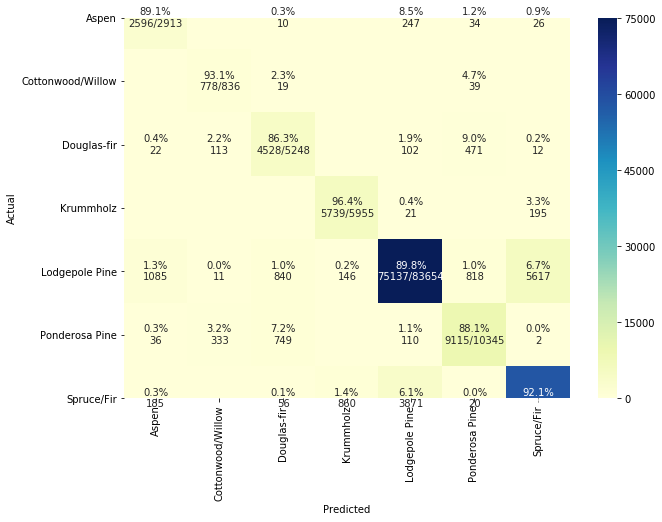

In [29]:
#Confusion Matrix for Decision Tree- Gini - class weights
def plot_cm(y_test_set, y_pred_set, figsize=(10,7)):
    cm = confusion_matrix(y_test_set, y_pred_set, labels=np.unique(y_test_set))
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test_set), columns=np.unique(y_test_set))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sb.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test_set, y_pred_set)

In [30]:
# from sklearn.model_selection import GridSearchCV
# def dtree_grid_search(X,y,nfolds):
#     #create a dictionary of all values we want to test
#     param_grid = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'min_samples_split' : range(2,20,2)}
#     # decision tree model
#     dtree_model=DecisionTreeClassifier(random_state=0, class_weight = class_wt)
#     #use gridsearch to test all values
#     dtree_gscv = GridSearchCV(dtree_model, param_grid,cv=nfolds)
#     #fit model to data
#     dtree_gscv.fit(X, y)
#     return dtree_gscv.best_params_

# print(dtree_grid_search(X_train_set,y_train_set,5))hot

In [31]:
#Decision Tree- Entropy - class weights
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

clf= DecisionTreeClassifier(criterion='entropy',random_state=0,min_samples_leaf=7,class_weight = class_wt)

y_pred_tree=clf.fit(X_train_set,y_train_set)

print("Decision Tree Training Accuracy=",y_pred_tree.score(X_train_set,y_train_set))
print("Decision Tree Test Accuracy=",y_pred_tree.score(X_test_set,y_test_set))

y_pred_set=clf.predict(X_test_set)

print(metrics.classification_report(y_test_set, y_pred_set, target_names=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))

print(metrics.confusion_matrix(y_test_set, y_pred_set, labels=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))


Decision Tree Training Accuracy= 0.9540391777557299
Decision Tree Test Accuracy= 0.9139483480688693
                   precision    recall  f1-score   support

       Spruce/Fir       0.68      0.89      0.77      2913
   Lodgepole Pine       0.68      0.93      0.78       836
   Ponderosa Pine       0.76      0.88      0.81      5248
Cottonwood/Willow       0.87      0.96      0.91      5955
            Aspen       0.95      0.91      0.93     83654
      Douglas-fir       0.88      0.89      0.88     10345
        Krummholz       0.91      0.93      0.92     62969

         accuracy                           0.91    171920
        macro avg       0.82      0.91      0.86    171920
     weighted avg       0.92      0.91      0.91    171920

[[58323  3677    25     0   154    55   735]
 [ 5207 75887   737     6  1006   694   117]
 [    5   125  9196   278    60   681     0]
 [    0     0    42   776     0    18     0]
 [   45   238    24     0  2590    16     0]
 [    2    90   433    

In [32]:
variable_import=dict(zip(X_train_set.columns, clf.feature_importances_))
print(variable_import)

{'Elevation': 0.5571459026468558, 'Slope': 0.01052140463116298, 'Hillshade_9am': 0.0325444205740079, 'Hillshade_Noon': 0.01565152727908937, 'Wilderness_Area1': 0.018242146708709987, 'Wilderness_Area2': 0.0007752507317713952, 'Wilderness_Area3': 0.013403049248850012, 'Wilderness_Area4': 0.005493446989926339, 'Soil_Type1': 0.0011720374392465065, 'Soil_Type2': 0.005472003174752342, 'Soil_Type3': 0.009206111513967474, 'Soil_Type4': 0.003850984289232119, 'Soil_Type5': 0.0008143198690024447, 'Soil_Type6': 0.001388801843770285, 'Soil_Type10': 0.006926592979339503, 'Soil_Type11': 0.0028526109933854266, 'Soil_Type12': 0.0024607594390085082, 'Soil_Type13': 0.003051688690856265, 'Soil_Type16': 0.0004888721956029479, 'Soil_Type17': 0.0022604869438726427, 'Soil_Type18': 0.0, 'Soil_Type22': 0.0010798151592448348, 'Soil_Type23': 0.0016975329935137555, 'Soil_Type24': 0.0009363817323282243, 'Soil_Type29': 0.0035756982622958005, 'Soil_Type30': 0.0013864481196855963, 'Soil_Type31': 0.0022882583462564133,

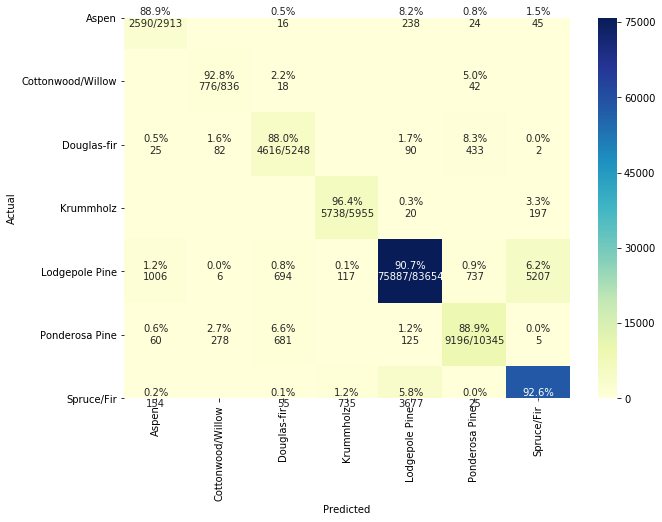

In [33]:
#Confusion Matrix for Decision Tree- Entropy - class weights
def plot_cm(y_test_set, y_pred_set, figsize=(10,7)):
    cm = confusion_matrix(y_test_set, y_pred_set, labels=np.unique(y_test_set))
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test_set), columns=np.unique(y_test_set))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sb.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test_set, y_pred_set)

In [39]:
#Linear Discriminant Analysis
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score 
from sklearn.utils import class_weight


clf = LinearDiscriminantAnalysis(n_components=6)
pred = clf.fit(X_train_set, y_train_set)
X_test_set1 = clf.transform(X_test_set)
#print(trans)
#plt.show()

classifier = LogisticRegression(solver='saga', max_iter=500,class_weight=class_wt)
pred2=classifier.fit(X_train_set, y_train_set)
pred1 = classifier.predict(X_test_set1)
#accuracy_score(pred,y_test_set)
#y_pred_lda=clf.fit(X_train_set,y_train_set)

print("LDA Training Accuracy_MLR=",pred2.score(X_train_set, y_train_set))
print("LDA Test Accuracy_MLR=",pred1.score(X_test_set1,y_test_set))
#y_pred_set=clf.predict(X_test_set)
print(metrics.classification_report(y_test_set, pred1, target_names=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))
print(metrics.confusion_matrix(y_test_set, pred1, labels=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))

C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ValueError: X has 6 features per sample; expecting 40

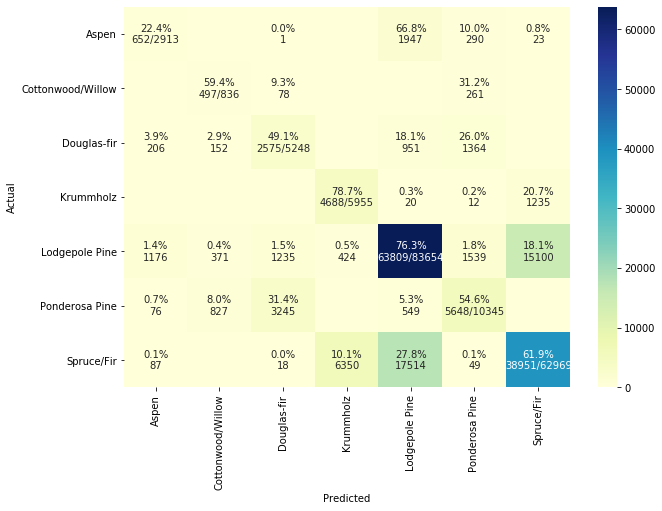

In [44]:
#Confusion Matrix for Linear Discriminant Analysis
def plot_cm(y_test_set, y_pred_set, figsize=(10,7)):
    cm = confusion_matrix(y_test_set, y_pred_set, labels=np.unique(y_test_set))
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test_set), columns=np.unique(y_test_set))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sb.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test_set, y_pred_set)

In [ ]:
#Setup arrays to store training and test accuracies
from sklearn import preprocessing
neighbors = [2,3,4,5,6,7]
neighbors = np.array(neighbors)

train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


In [ ]:
%%time
for i in range(len(neighbors)):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=neighbors[i])

   #Fit the model
    knn.fit(X_train_set, y_train_set)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_set, y_train_set)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test_set, y_test_set)

In [ ]:
plt.title('k-NN Accuracy for upto 7 neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

As per the plot above, we get the best model when the number of neighbours = 5

In [37]:
#Setting up a classifier for number of neighbours = 5
knn = KNeighborsClassifier(n_neighbors=5)

In [38]:
#Fit the model
knn.fit(X_train_set,y_train_set)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [39]:
#Getting accuracy of the model
Accuracy=knn.score(X_test_set,y_test_set)
print('KNN Accuracy:',Accuracy)

KNN Accuracy: 0.9639134481154025


In [19]:
#logistic Regression 
classifier = LogisticRegression()
classifier.fit( X_train_set , y_train_set )
pred = classifier.predict(X_test_set)
accuracy_score(pred , y_test_set)

C:\Users\Janhavi Powale\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6245579339227547

In [40]:
#Linear Discriminant Analysis
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=6)
y_pred_lda=clf.fit(X_train_set,y_train_set)

print("LDA Training Accuracy=",y_pred_lda.score(X_train_set,y_train_set))
print("LDA Test Accuracy=",y_pred_lda.score(X_test_set,y_test_set))
y_pred_set=clf.predict(X_test_set)
print(metrics.classification_report(y_test_set, y_pred_set, target_names=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))
print(metrics.confusion_matrix(y_test_set, y_pred_set, labels=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))

LDA Training Accuracy= 0.680350794972404
LDA Test Accuracy= 0.6799674267100977
                   precision    recall  f1-score   support

       Spruce/Fir       0.31      0.25      0.28      2913
   Lodgepole Pine       0.27      0.59      0.37       836
   Ponderosa Pine       0.36      0.50      0.42      5248
Cottonwood/Willow       0.41      0.79      0.54      5955
            Aspen       0.75      0.76      0.76     83654
      Douglas-fir       0.62      0.54      0.58     10345
        Krummholz       0.70      0.62      0.66     62969

         accuracy                           0.68    171920
        macro avg       0.49      0.58      0.51    171920
     weighted avg       0.69      0.68      0.68    171920

[[38907 17494    49     0   142    27  6350]
 [15034 63887  1539   372  1160  1238   424]
 [    0   551  5596   820    79  3299     0]
 [    0     0   259   496     0    81     0]
 [   32  1864   290     0   726     1     0]
 [    0   962  1333   151   202  2600     0]

In [42]:
#Multinomial Logistic Regression - NIL
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train_set)
X_std_test = scaler.fit_transform(X_test_set)
clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='saga',class_weight='balanced', max_iter =2000)
y_pred_mlr=clf.fit(X_std,y_train_set)
print("Multinomial Logistic regression Train Accuracy", y_pred_mlr.score(X_std,y_train_set))
print("Multinomial Logistic regression Test Accuracy", y_pred_mlr.score(X_std_test,y_test_set,))
print(metrics.classification_report(y_test_set, y_pred_set, target_names=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))
print(metrics.confusion_matrix(y_test_set, y_pred_set, labels=["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine","Cottonwood/Willow", "Aspen", "Douglas-fir","Krummholz"]))


C:\Users\shrut\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Multinomial Logistic regression Train Accuracy 0.5976577106589621
Multinomial Logistic regression Test Accuracy 0.5969229874360168
                   precision    recall  f1-score   support

       Spruce/Fir       0.31      0.25      0.28      2913
   Lodgepole Pine       0.27      0.59      0.37       836
   Ponderosa Pine       0.36      0.50      0.42      5248
Cottonwood/Willow       0.41      0.79      0.54      5955
            Aspen       0.75      0.76      0.76     83654
      Douglas-fir       0.62      0.54      0.58     10345
        Krummholz       0.70      0.62      0.66     62969

         accuracy                           0.68    171920
        macro avg       0.49      0.58      0.51    171920
     weighted avg       0.69      0.68      0.68    171920

[[38907 17494    49     0   142    27  6350]
 [15034 63887  1539   372  1160  1238   424]
 [    0   551  5596   820    79  3299     0]
 [    0     0   259   496     0    81     0]
 [   32  1864   290     0   726     1